In [1]:
import torch
from tqdm import tqdm
import argparse
import torch
from model.bgrl import BGRL
from model.edieggc import EDiEGGC
from data.data import QM9Dataloader
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
parser = argparse.ArgumentParser(description='dipole moment prediction training')
"""Experiment setting."""
parser.add_argument('--exp-name', type=str, default='qm9_20_mmff_pot_b', help="Save experiment name")
parser.add_argument('--lacl', type=bool, default=True, help="True for training LACL, False for training")
parser.add_argument('--finetune', type=bool, default=False, help="")
parser.add_argument('--freeze', type=bool, default=False, help="")
parser.add_argument('--update_moving_average', type=bool, default=True, help="For BGRL")
parser.add_argument('--loss', type=str, default='contrastive+prediction', help="")
parser.add_argument('--num-workers', type=int, default=6, help="Number of workers for dataloader")
parser.add_argument('--dataset', type=str, default='QM9', help="QM9 or QMugs")
parser.add_argument('--set', type=str, default='src', help="'src' for source domain and 'tgt' for target domain")
parser.add_argument('--target', type=str, default='gap', help="homo, lumo, gap, mu, ...")
parser.add_argument('--geometry', type=str, default='CGCF', help="")
parser.add_argument('--epochs', type=int, default=300, help="")
parser.add_argument('--num-train', type=int, default=110000, help="110000/65000")
parser.add_argument('--num-valid', type=int, default=10000, help="10000/1500")
parser.add_argument('--num-test', type=int, default=10829, help="10829/1706")
parser.add_argument('--batch-size', type=int, default=32, help="")
parser.add_argument('--learning-rate', type=float, default=1e-3, help="")
parser.add_argument('--weight-decay', type=float, default=0, help="")
parser.add_argument('--max-norm', type=float, default=1000.0, help="")
parser.add_argument('--scheduler', type=str, default='plateau', help="")
parser.add_argument('--cutoff', type=float, default=5.0, help="")
parser.add_argument('--device', type=str, default='cuda:1', help="cuda device")
'''Model setting'''
parser.add_argument('--embedding-type', type=str, default='cgcnn', help="")
parser.add_argument('--alignn-layers', type=int, default=4, help="")
parser.add_argument('--gcn-layers', type=int, default=4, help="")
parser.add_argument('--atom-input-features', type=int, default=92, help="")
parser.add_argument('--edge-input-features', type=int, default=80, help="")
parser.add_argument('--triplet-input-features', type=int, default=40, help="")
parser.add_argument('--embedding-features', type=int, default=64, help="")
parser.add_argument('--hidden-features', type=int, default=256, help="")
parser.add_argument('--output-features', type=int, default=1, help="")
args = parser.parse_args(args=[])


In [3]:
def return_prediction(model_b, model_g):
    train_loader, valid_loader, test_loader, test_indices = QM9Dataloader(args)
    del train_loader, valid_loader
    bgrl_trained_model = BGRL(args).to(args.device)
    # Change relative path of saved model
    bgrl_trained_model.load_state_dict(torch.load(model_b))
    bgrl_trained_model.eval()

    alignn_trained_model = EDiEGGC(args).to(args.device)
    # Change relative path of saved model
    alignn_trained_model.load_state_dict(torch.load(model_g))
    alignn_trained_model.eval()
    print('')

    # y_embs = torch.tensor([]).to(args.device)
    bgrl_trained_g_embs_1 = torch.tensor([]).to(args.device)
    alignn_trained_g_embs_1 = torch.tensor([]).to(args.device)
    bgrl_trained_g_embs_2 = torch.tensor([]).to(args.device)
    alignn_trained_g_embs_2 = torch.tensor([]).to(args.device)

    label_tensor = torch.tensor([]).to(args.device)
    for g1, lg1, g2, lg2, labels in tqdm(test_loader):
        g1 = g1.to(args.device)
        lg1 = lg1.to(args.device)
        g2 = g2.to(args.device)
        lg2 = lg2.to(args.device)
        labels = labels.to(args.device)
        with torch.no_grad():
            pred1, pred2, loss, v, x, y, z = bgrl_trained_model(g1, lg1, g2, lg2)
            bgrl_trained_g_embs_1 = torch.concat([bgrl_trained_g_embs_1, pred1.detach()])
        
            pred1, pred2, loss, v, x, y, z = bgrl_trained_model(g2, lg2, g2, lg2)
            bgrl_trained_g_embs_2 = torch.concat([bgrl_trained_g_embs_2, pred1.detach()])

            pred, v, x, y, z = alignn_trained_model(g1, lg1)
            alignn_trained_g_embs_1 = torch.concat([alignn_trained_g_embs_1, pred.detach()])

            pred, v, x, y, z = alignn_trained_model(g2, lg2)
            alignn_trained_g_embs_2 = torch.concat([alignn_trained_g_embs_2, pred.detach()])
        label_tensor = torch.concat([label_tensor, labels.detach()])
    # model x init_train x geometry x x_g = 16
    bgrl_trained_g_embs_1 = bgrl_trained_g_embs_1.cpu()
    alignn_trained_g_embs_1 = alignn_trained_g_embs_1.cpu()
    bgrl_trained_g_embs_2 = bgrl_trained_g_embs_2.cpu()
    alignn_trained_g_embs_2 = alignn_trained_g_embs_2.cpu()
    label_tensor = label_tensor.cpu()

    bgrl_trained_model = bgrl_trained_model.to('cpu')
    alignn_trained_model = alignn_trained_model.to('cpu')
    return bgrl_trained_g_embs_1, bgrl_trained_g_embs_2, alignn_trained_g_embs_1, alignn_trained_g_embs_2, label_tensor

In [8]:
args.target = 'mu'
b_g_mu, b_sg_mu, g_g_mu, g_sg_mu, l_mu = return_prediction('ckpts/qm9_mmff_mu_b', 'ckpts/qm9_mmff_mu_g')
args.target = 'homo'
b_g_homo, b_sg_homo, g_g_homo, g_sg_homo, l_homo = return_prediction('ckpts/qm9_mmff_homo_b', 'ckpts/qm9_mmff_homo_g')
args.target = 'lumo'
b_g_lumo, b_sg_lumo, g_g_lumo, g_sg_lumo, l_lumo = return_prediction('ckpts/qm9_mmff_lumo_b', 'ckpts/qm9_mmff_lumo_g')
args.target = 'gap'
b_g_gap, b_sg_gap, g_g_gap, g_sg_gap, l_gap = return_prediction('ckpts/qm9_mmff_gap_b', 'ckpts/qm9_mmff_gap_g')
args.target = 'U0'
b_g_U0, b_sg_U0, g_g_U0, g_sg_U0, l_U0 = return_prediction('ckpts/qm9_mmff_U0_b', 'ckpts/qm9_mmff_U0_g')
args.target = 'G'
b_g_G, b_sg_G, g_g_G, g_sg_G, l_G = return_prediction('ckpts/qm9_mmff_G_b', 'ckpts/qm9_mmff_G_g')

100%|██████████| 133855/133855 [03:09<00:00, 704.62it/s] 


100%|██████████| 133855/133855 [03:07<00:00, 714.30it/s] 


100%|██████████| 133855/133855 [03:07<00:00, 714.03it/s] 


100%|██████████| 339/339 [02:00<00:00,  2.82it/s]


In [12]:
# args.target = 'mu'
# b_g_mu, b_sg_mu, g_g_mu, g_sg_mu, l_mu = return_prediction('ckpts/qm9_cgcf_mu_b', 'ckpts/qm9_cgcf_mu_g')
# args.target = 'homo'
# b_g_homo, b_sg_homo, g_g_homo, g_sg_homo, l_homo = return_prediction('ckpts/qm9_cgcf_homo_b', 'ckpts/qm9_cgcf_homo_g')
# args.target = 'lumo'
# b_g_lumo, b_sg_lumo, g_g_lumo, g_sg_lumo, l_lumo = return_prediction('ckpts/qm9_cgcf_lumo_b', 'ckpts/qm9_cgcf_lumo_g')
# args.target = 'gap'
# b_g_gap, b_sg_gap, g_g_gap, g_sg_gap, l_gap = return_prediction('ckpts/qm9_cgcf_gap_b', 'ckpts/qm9_cgcf_gap_g')
args.target = 'U0'
b_g_U0, b_sg_U0, g_g_U0, g_sg_U0, l_U0 = return_prediction('ckpts/qm9_cgcf_U0_b', 'ckpts/qm9_cgcf_U0_src')
args.target = 'G'
b_g_G, b_sg_G, g_g_G, g_sg_G, l_G = return_prediction('ckpts/qm9_cgcf_G_b', 'ckpts/qm9_cgcf_G_src')

100%|██████████| 133855/133855 [03:15<00:00, 685.84it/s] 


100%|██████████| 133855/133855 [03:21<00:00, 665.32it/s] 


100%|██████████| 339/339 [01:55<00:00,  2.93it/s]


In [7]:
pd.DataFrame({
    'label_mu': l_mu,
    'label_homo': l_homo,
    'label_lumo': l_lumo,
    'label_gap': l_gap,
    'label_U0': l_U0,
    'label_G': l_G,
    'pred_source_finetune_source_mu': g_g_mu,
    'pred_source_finetune_target_mu': g_sg_mu,
    'pred_lacl_source_mu': b_g_mu,
    'pred_lacl_target_mu': b_sg_mu,
    'pred_source_finetune_source_homo': g_g_homo,
    'pred_source_finetune_target_homo': g_sg_homo,
    'pred_lacl_source_homo': b_g_homo,
    'pred_lacl_target_homo': b_sg_homo,
    'pred_source_finetune_source_lumo': g_g_lumo,
    'pred_source_finetune_target_lumo': g_sg_lumo,
    'pred_lacl_source_lumo': b_g_lumo,
    'pred_lacl_target_lumo': b_sg_lumo,
    'pred_source_finetune_source_gap': g_g_gap,
    'pred_source_finetune_target_gap': g_sg_gap,
    'pred_lacl_source_gap': b_g_gap,
    'pred_lacl_target_gap': b_sg_gap,
    'pred_source_finetune_source_U0': g_g_U0,
    'pred_source_finetune_target_U0': g_sg_U0,
    'pred_lacl_source_U0': b_g_U0,
    'pred_lacl_target_U0': b_sg_U0,
    'pred_source_finetune_source_G': g_g_G,
    'pred_source_finetune_target_G': g_sg_G,
    'pred_lacl_source_G': b_g_G,
    'pred_lacl_target_G': b_sg_G,
}).to_csv('images/extended_data_1a.csv')

In [5]:
#load csv
df = pd.read_csv('images/extended_data_1a.csv')
l_mu = df['label_mu']
l_homo = df['label_homo']
l_lumo = df['label_lumo']
l_gap = df['label_gap']
l_U0 = df['label_U0']
l_G = df['label_G']

g_g_mu = df['pred_source_finetune_source_mu']
g_sg_mu = df['pred_source_finetune_target_mu']
b_g_mu = df['pred_lacl_source_mu']
b_sg_mu = df['pred_lacl_target_mu']

g_g_homo = df['pred_source_finetune_source_homo']
g_sg_homo = df['pred_source_finetune_target_homo']
b_g_homo = df['pred_lacl_source_homo']
b_sg_homo = df['pred_lacl_target_homo']

g_g_lumo = df['pred_source_finetune_source_lumo']
g_sg_lumo = df['pred_source_finetune_target_lumo']
b_g_lumo = df['pred_lacl_source_lumo']
b_sg_lumo = df['pred_lacl_target_lumo']

g_g_gap = df['pred_source_finetune_source_gap']
g_sg_gap = df['pred_source_finetune_target_gap']
b_g_gap = df['pred_lacl_source_gap']
b_sg_gap = df['pred_lacl_target_gap']

# g_g_U0 = df['pred_source_finetune_source_U0']
# g_sg_U0 = df['pred_source_finetune_target_U0']
# b_g_U0 = df['pred_lacl_source_U0']
# b_sg_U0 = df['pred_lacl_target_U0']

# g_g_G = df['pred_source_finetune_source_G']
# g_sg_G = df['pred_source_finetune_target_G']
# b_g_G = df['pred_lacl_source_G']
# b_sg_G = df['pred_lacl_target_G']


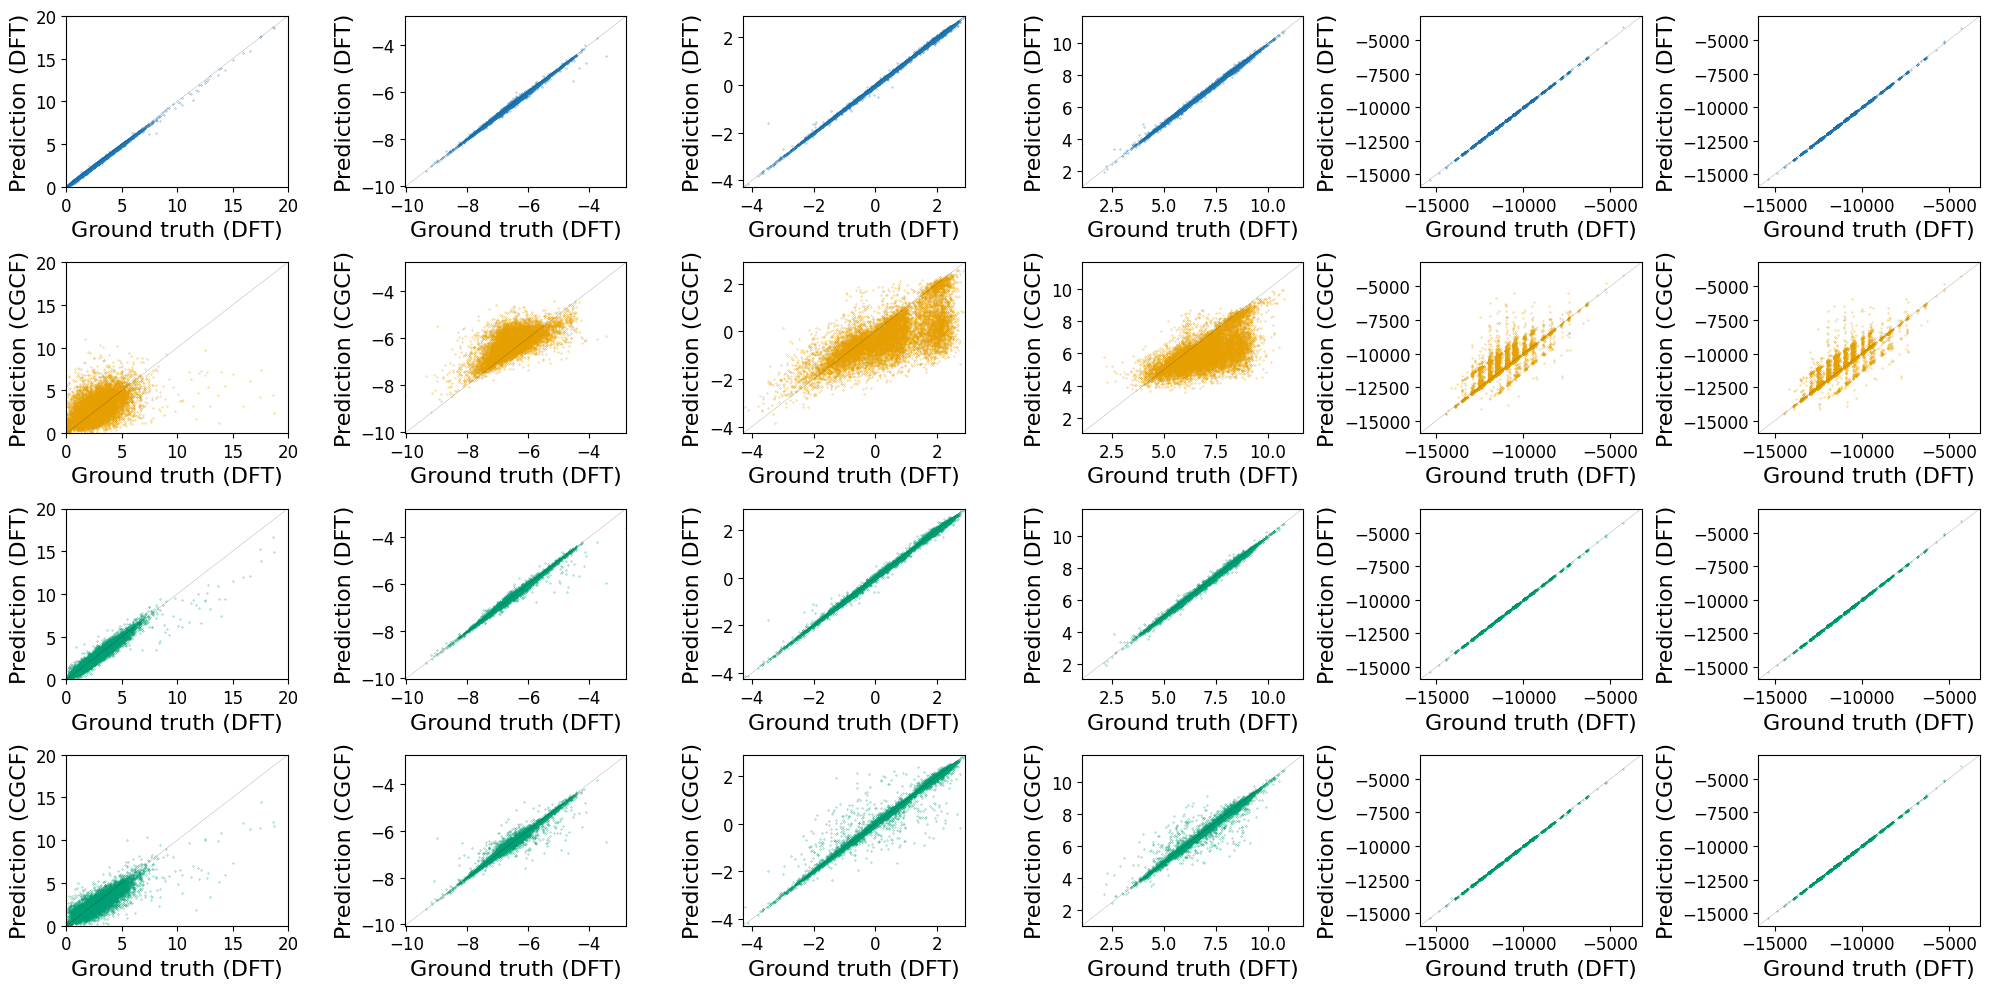

In [15]:
plt.figure(figsize=(20, 10))
fontdict = {'fontsize':16}

lim = 20
ax1 = plt.subplot(4,6,1)
plt.scatter(l_mu, g_g_mu, s=0.05)
plt.plot([0,lim], [0,lim], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (DFT)', fontdict=fontdict)
plt.xlim(0,lim)
plt.ylim(0,lim)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,7)
plt.scatter(l_mu, g_sg_mu, s=0.05, c='#E69F00')
plt.plot([0,lim], [0,lim], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (CGCF)', fontdict=fontdict)
plt.xlim(0,lim)
plt.ylim(0,lim)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,13)
plt.scatter(l_mu, b_g_mu, s=0.05, c='#009E73')
plt.plot([0,lim], [0,lim], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (DFT)', fontdict=fontdict)
plt.xlim(0,lim)
plt.ylim(0,lim)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,19)
plt.scatter(l_mu, b_sg_mu, s=0.05, c='#009E73')
plt.plot([0,lim], [0,lim], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (CGCF)', fontdict=fontdict)
plt.xlim(0,lim)
plt.ylim(0,lim)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

ax1 = plt.subplot(4,6,2)
plt.scatter(l_homo, g_g_homo, s=0.05)
plt.plot([min(l_homo), max(l_homo)], [min(l_homo), max(l_homo)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (DFT)', fontdict=fontdict)
plt.xlim(min(l_homo), max(l_homo))
plt.ylim(min(l_homo), max(l_homo))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,8)
plt.scatter(l_homo, g_sg_homo, s=0.05, c='#E69F00')
plt.plot([min(l_homo), max(l_homo)], [min(l_homo), max(l_homo)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (CGCF)', fontdict=fontdict)
plt.xlim(min(l_homo), max(l_homo))
plt.ylim(min(l_homo), max(l_homo))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,14)
plt.scatter(l_homo, b_g_homo, s=0.05, c='#009E73')
plt.plot([min(l_homo), max(l_homo)], [min(l_homo), max(l_homo)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (DFT)', fontdict=fontdict)
plt.xlim(min(l_homo), max(l_homo))
plt.ylim(min(l_homo), max(l_homo))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,20)
plt.scatter(l_homo, b_sg_homo, s=0.05, c='#009E73')
plt.plot([min(l_homo), max(l_homo)], [min(l_homo), max(l_homo)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (CGCF)', fontdict=fontdict)
plt.xlim(min(l_homo), max(l_homo))
plt.ylim(min(l_homo), max(l_homo))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)


ax1 = plt.subplot(4,6,3)
plt.scatter(l_lumo, g_g_lumo, s=0.05)
plt.plot([min(l_lumo), max(l_lumo)], [min(l_lumo), max(l_lumo)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (DFT)', fontdict=fontdict)
plt.xlim(min(l_lumo), max(l_lumo))
plt.ylim(min(l_lumo), max(l_lumo))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,9)
plt.scatter(l_lumo, g_sg_lumo, s=0.05, c='#E69F00')
plt.plot([min(l_lumo), max(l_lumo)], [min(l_lumo), max(l_lumo)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (CGCF)', fontdict=fontdict)
plt.xlim(min(l_lumo), max(l_lumo))
plt.ylim(min(l_lumo), max(l_lumo))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,15)
plt.scatter(l_lumo, b_g_lumo, s=0.05, c='#009E73')
plt.plot([min(l_lumo), max(l_lumo)], [min(l_lumo), max(l_lumo)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (DFT)', fontdict=fontdict)
plt.xlim(min(l_lumo), max(l_lumo))
plt.ylim(min(l_lumo), max(l_lumo))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,21)
plt.scatter(l_lumo, b_sg_lumo, s=0.05, c='#009E73')
plt.plot([min(l_lumo), max(l_lumo)], [min(l_lumo), max(l_lumo)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (CGCF)', fontdict=fontdict)
plt.xlim(min(l_lumo), max(l_lumo))
plt.ylim(min(l_lumo), max(l_lumo))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)


ax1 = plt.subplot(4,6,4)
plt.scatter(l_gap, g_g_gap, s=0.05)
plt.plot([min(l_gap), max(l_gap)], [min(l_gap), max(l_gap)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (DFT)', fontdict=fontdict)
plt.xlim(min(l_gap), max(l_gap))
plt.ylim(min(l_gap), max(l_gap))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,10)
plt.scatter(l_gap, g_sg_gap, s=0.05, c='#E69F00')
plt.plot([min(l_gap), max(l_gap)], [min(l_gap), max(l_gap)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (CGCF)', fontdict=fontdict)
plt.xlim(min(l_gap), max(l_gap))
plt.ylim(min(l_gap), max(l_gap))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,16)
plt.scatter(l_gap, b_g_gap, s=0.05, c='#009E73')
plt.plot([min(l_gap), max(l_gap)], [min(l_gap), max(l_gap)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (DFT)', fontdict=fontdict)
plt.xlim(min(l_gap), max(l_gap))
plt.ylim(min(l_gap), max(l_gap))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,22)
plt.scatter(l_gap, b_sg_gap, s=0.05, c='#009E73')
plt.plot([min(l_gap), max(l_gap)], [min(l_gap), max(l_gap)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (CGCF)', fontdict=fontdict)
plt.xlim(min(l_gap), max(l_gap))
plt.ylim(min(l_gap), max(l_gap))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)


ax1 = plt.subplot(4,6,5)
plt.scatter(l_U0, g_g_U0, s=0.05)
plt.plot([min(l_U0), max(l_U0)], [min(l_U0), max(l_U0)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (DFT)', fontdict=fontdict)
plt.xlim(min(l_U0), max(l_U0))
plt.ylim(min(l_U0), max(l_U0))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,11)
plt.scatter(l_U0, g_sg_U0, s=0.05, c='#E69F00')
plt.plot([min(l_U0), max(l_U0)], [min(l_U0), max(l_U0)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (CGCF)', fontdict=fontdict)
plt.xlim(min(l_U0), max(l_U0))
plt.ylim(min(l_U0), max(l_U0))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,17)
plt.scatter(l_U0, b_g_U0, s=0.05, c='#009E73')
plt.plot([min(l_U0), max(l_U0)], [min(l_U0), max(l_U0)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (DFT)', fontdict=fontdict)
plt.xlim(min(l_U0), max(l_U0))
plt.ylim(min(l_U0), max(l_U0))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,23)
plt.scatter(l_U0, b_sg_U0, s=0.05, c='#009E73')
plt.plot([min(l_U0), max(l_U0)], [min(l_U0), max(l_U0)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (CGCF)', fontdict=fontdict)
plt.xlim(min(l_U0), max(l_U0))
plt.ylim(min(l_U0), max(l_U0))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)


ax1 = plt.subplot(4,6,6)
plt.scatter(l_G, g_g_G, s=0.05)
plt.plot([min(l_G), max(l_G)], [min(l_G), max(l_G)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (DFT)', fontdict=fontdict)
plt.xlim(min(l_G), max(l_G))
plt.ylim(min(l_G), max(l_G))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,12)
plt.scatter(l_G, g_sg_G, s=0.05, c='#E69F00')
plt.plot([min(l_G), max(l_G)], [min(l_G), max(l_G)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (CGCF)', fontdict=fontdict)
plt.xlim(min(l_G), max(l_G))
plt.ylim(min(l_G), max(l_G))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,18)
plt.scatter(l_G, b_g_G, s=0.05, c='#009E73')
plt.plot([min(l_G), max(l_G)], [min(l_G), max(l_G)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (DFT)', fontdict=fontdict)
plt.xlim(min(l_G), max(l_G))
plt.ylim(min(l_G), max(l_G))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,24)
plt.scatter(l_G, b_sg_G, s=0.05, c='#009E73')
plt.plot([min(l_G), max(l_G)], [min(l_G), max(l_G)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (CGCF)', fontdict=fontdict)
plt.xlim(min(l_G), max(l_G))
plt.ylim(min(l_G), max(l_G))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)


plt.tight_layout()

plt.savefig(f'./images/parity_plot_{args.geometry}.pdf', transparent=True, dpi=500)
plt.savefig(f'./images/parity_plot_{args.geometry}.tif', transparent=True, dpi=500)